# Notebook 01: Single Patient Baseline Simulations

## Purpose
This notebook validates the core PBPK/PD model components through single-patient baseline simulations. It serves as a sanity check to ensure each subsystem (PK, immune trafficking, tumor dynamics) behaves physiologically before running complex population studies.

## Contents
1. **PK Sanity Check**: Single 1-nmol SC bolus to verify drug absorption and clearance
2. **Immune Trafficking**: 30-day simulation without drug to verify T-cell and B-cell homeostasis
3. **Tumor Growth**: Baseline tumor dynamics to validate growth kinetics
4. **Full System Integration**: Combined PBPK/PD with realistic dosing regimen

## Key Validation Points
- Plasma concentration profiles show expected absorption/elimination kinetics
- T-cell and B-cell compartments maintain homeostasis (AF → 1.0)
- Tumor growth follows logistic kinetics
- No numerical instabilities or solver failures

## Usage
Run cells sequentially to verify model stability. Each section includes plots and printed diagnostics to confirm expected behavior.

---


In [11]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt 
import numpy as np

NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent 
sys.path.append(str(PROJECT_ROOT))
print("Added to sys.path:", PROJECT_ROOT)

Added to sys.path: D:\User Data\Downloads\epcoritamab-pbpk-pd


#### 1. Sanity check: single SC bolus (unit dose)

Before using realistic doses and clinical regimens, we first verify that the PBPK submodel behaves sensibly for a very simple case: a **single 1-nmol SC bolus** into the depot compartment.

In this cell we:

* Construct default model parameters (`get_default_parameters`).
* Apply a one-time SC dose using `single_sc_bolus(dose_nmol=1.0)`.
* Simulate the system and extract the plasma drug amount.
* Convert plasma amount → concentration by dividing by `Vplasma`.

The printed summary (time/vector shapes and Cmax) confirms that the solver is behaving as expected, and the plot shows a smooth rise and mono-exponential decay in plasma concentration driven purely by the PK model.

This section is intentionally **unit-agnostic** (1 nmol rather than a clinical mg dose); later sections will plug in the real trial-like dosing regimens and compare to the paper’s figures.



t shape: (250,)
y shape: (43, 250)
first 5 time points: [0.         0.3373494  0.6746988  1.01204819 1.34939759]
first 5 plasma concs: [0.         0.00092989 0.00261642 0.00431054 0.00576991]
Cmax_plasma: 0.009379264884574317
Cmin_plasma: 0.0


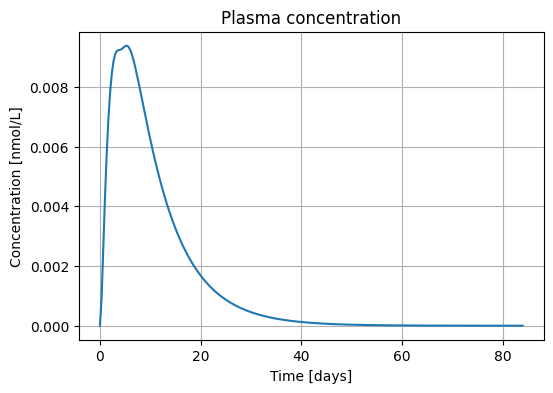

In [12]:
from src.epco_model.parameters import get_default_parameters
from src.epco_model.dosing import single_sc_bolus
from src.epco_model.simulation import simulate_patient
from src.epco_model.state_vector import StateIx
from src.epco_model.plotting import plot_plasma_concentration


# mechanics check: single 1-nmol SC bolus 
params = get_default_parameters()
dosing = single_sc_bolus(dose_nmol=1.0) # temp unit dose of 1 nmol

t, y = simulate_patient(params, dosing)

pk = params.pk
A_plasma = y[StateIx.DRUG_PLASMA]
C_plasma = A_plasma / pk.Vplasma

print("t shape:", t.shape)
print("y shape:", y.shape)
print("first 5 time points:", t[:5])
print("first 5 plasma concs:", C_plasma[:5])
print("Cmax_plasma:", C_plasma.max())
print("Cmin_plasma:", C_plasma.min())

ax = plot_plasma_concentration(t, y, params)
plt.show()

### Sanity Check: Trafficking & Homeostasis Without Drug

Before introducing epcoritamab into the system, we verify that the PBPK + immune trafficking subsystem behaves correctly on its own. This simulation runs **30 days with no dosing** (empty `DosingRegimen`) and checks:

* **T-cell compartments** (blood, spleen, node, lymph) should remain stable or show slow physiological drift.
* **B-cell compartments** should similarly maintain homeostasis.
* **Adaptive feedback states** `AF_T` and `AF_B` should converge toward **1.0**, confirming correct implementation of the homeostatic feedback loop.
* **INJ(t)** decays toward zero, confirming correct handling of injection-related transient effects when no drug is present.

These plots provide a baseline reference to ensure the trafficking subsystem is stable and physiologically consistent *before adding drug, binding, ATC expansion, or tumor dynamics*.



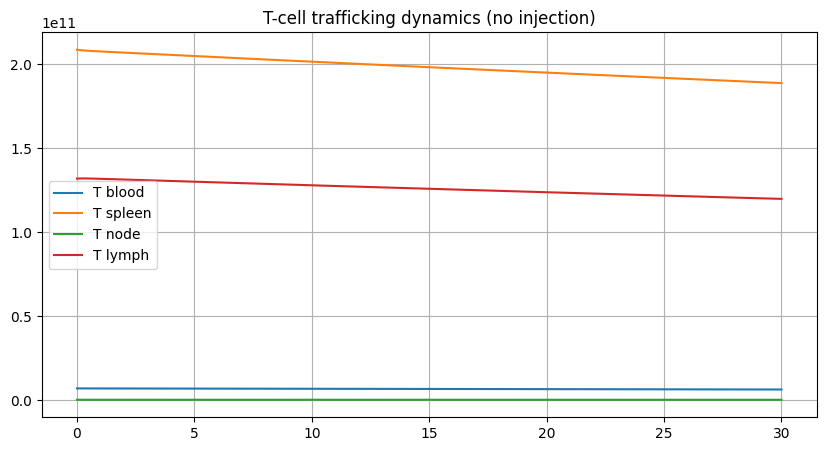

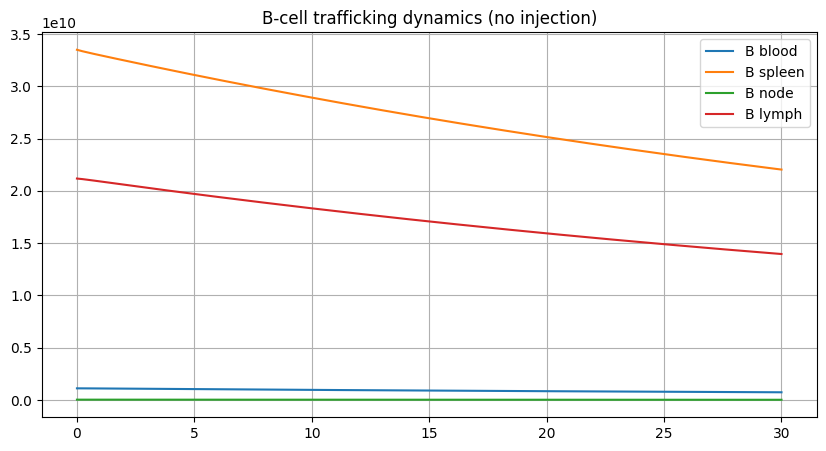

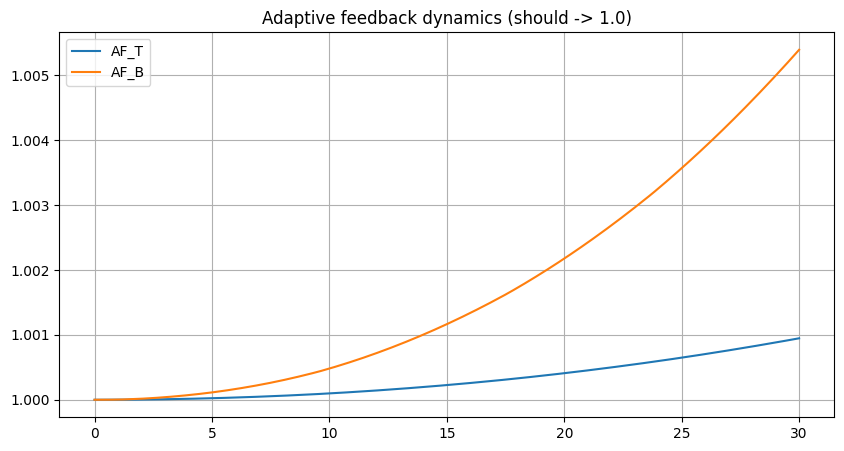

Final INJ: 0.0


In [13]:
from src.epco_model.parameters import get_default_parameters
from src.epco_model.simulation import simulate_patient
from src.epco_model.dosing import single_sc_bolus
from src.epco_model.state_vector import StateIx

# 1. No dosing at all (test just trafficking)
params = get_default_parameters()

# Create an empty dosing object: a single SC bolus of 0
from src.epco_model.dosing import DosingRegimen, DoseEvent
dosing = DosingRegimen(events=[])

# Simulate
t, y = simulate_patient(params, dosing, t_span=(0, 30))

# Extract T/B states
T_blood = y[StateIx.T_BLOOD]
T_spleen = y[StateIx.T_SPLEEN]
T_node   = y[StateIx.T_NODE]
T_lymph  = y[StateIx.T_LYMPH]

B_blood = y[StateIx.B_BLOOD]
B_spleen = y[StateIx.B_SPLEEN]
B_node   = y[StateIx.B_NODE]
B_lymph  = y[StateIx.B_LYMPH]

AF_T = y[StateIx.AF_T]
AF_B = y[StateIx.AF_B]
INJ  = y[StateIx.INJ]

# Plot T cells
plt.figure(figsize=(10,5))
plt.plot(t, T_blood, label="T blood")
plt.plot(t, T_spleen, label="T spleen")
plt.plot(t, T_node, label="T node")
plt.plot(t, T_lymph, label="T lymph")
plt.title("T-cell trafficking dynamics (no injection)")
plt.legend(); plt.grid(); plt.show()

# Plot B cells
plt.figure(figsize=(10,5))
plt.plot(t, B_blood, label="B blood")
plt.plot(t, B_spleen, label="B spleen")
plt.plot(t, B_node, label="B node")
plt.plot(t, B_lymph, label="B lymph")
plt.title("B-cell trafficking dynamics (no injection)")
plt.legend(); plt.grid(); plt.show()

# Plot AF
plt.figure(figsize=(10,5))
plt.plot(t, AF_T, label="AF_T")
plt.plot(t, AF_B, label="AF_B")
plt.title("Adaptive feedback dynamics (should -> 1.0)")
plt.legend(); plt.grid(); plt.show()

print("Final INJ:", INJ[-1])

#### Single-patient summary: PK/PD and tumor response

Here I run a single virtual patient through the model and visualize all key sub-modules:

* Plasma PK (epcoritamab concentrations over time)
* Tumor vs B-cell trimers in the lymph node
* Tumor burden (total cells + equivalent radius)
* Tumor-directed activated T cells (ATC and pATC)
* B-cell depletion in blood

Below the plots, I also print scalar summary metrics (Cmax, AUC, tumor fraction at day 84, and B-cell fraction at day 84). This cell serves as a quick end-to-end sanity check that the PBPK/PD model is behaving reasonably before moving on to clinical trial–like dosing and population simulations.

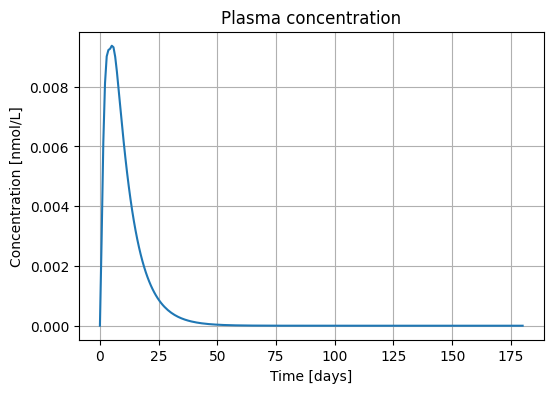

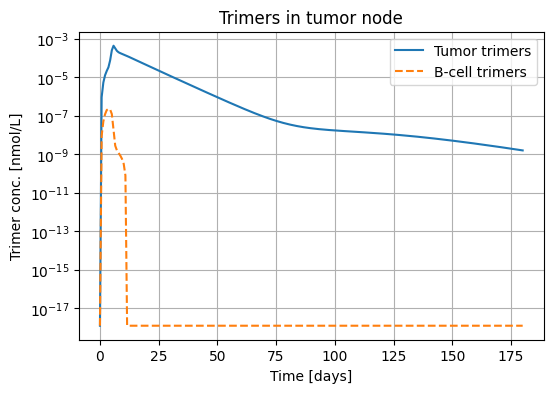

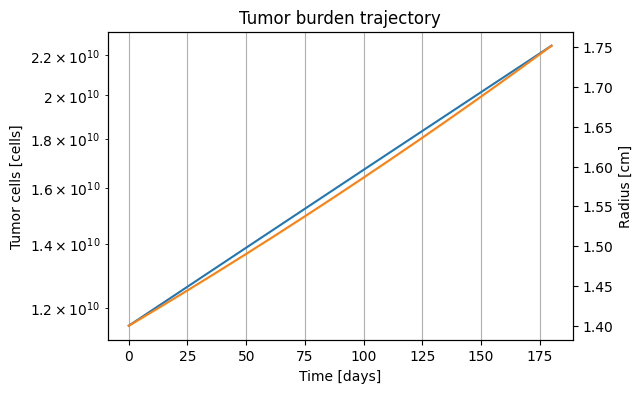

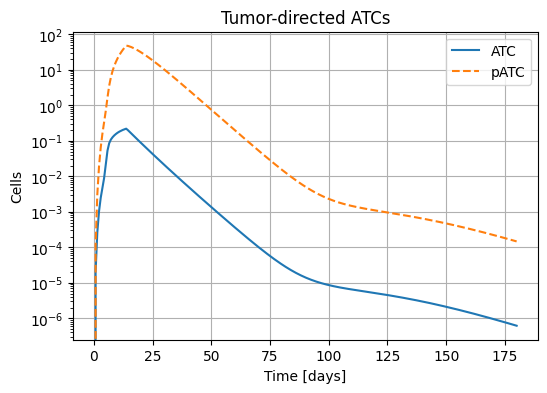

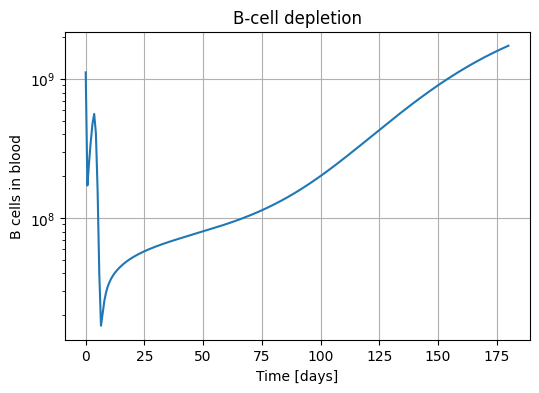

Cmax_plasma: 0.009370894933891084
AUC_plasma (rough): 0.12369198370623666
Tumor N0: 11494040321.933851
Tumor N84: 15737273419.926908 (fraction: 1.3691681061789716 )
B0: 1116280000.0
B84: 135047161.24817097 (fraction: 0.12097964780178 )


In [14]:
from src.epco_model.parameters import get_default_parameters
from src.epco_model.dosing import single_sc_bolus
from src.epco_model.simulation import simulate_patient

params = get_default_parameters()
dosing = single_sc_bolus(dose_amount=1.0) # temp unit dose 
t, y = simulate_patient(params, dosing, t_span=(0, 180))
y_plot = np.maximum(y, 1e-20)


from src.epco_model import plotting as epplot

# 1) Plasma PK
epplot.plot_plasma_concentration(t, y, params)
plt.show()

# 2) Node trimers (tumor vs B)
epplot.plot_node_trimers(t, y_plot, params)
plt.show()

# 3) Tumor trajectory
epplot.plot_tumor_trajectory(t, y)
plt.show()

# 4) Tumor-directed ATCs
epplot.plot_tumor_ATCs(t, y)
plt.show()

# 5) B-cell depletion 
epplot.plot_bcell_depletion(t, y)
plt.show()


# PK
C_plasma = y[StateIx.DRUG_PLASMA] / params.pk.Vplasma
print("Cmax_plasma:", C_plasma.max())
print("AUC_plasma (rough):", np.trapezoid(C_plasma, t))

# Tumor
N0 = y[StateIx.TUMOR_CELLS_TOTAL, 0]
N84 = y[StateIx.TUMOR_CELLS_TOTAL, np.argmin(np.abs(t - 84))]
print("Tumor N0:", N0)
print("Tumor N84:", N84, "(fraction:", N84 / N0, ")")

# B cells
B0 = y[StateIx.B_BLOOD, 0]
B84 = y[StateIx.B_BLOOD, np.argmin(np.abs(t - 84))]
print("B0:", B0)
print("B84:", B84, "(fraction:", B84 / B0, ")")

### Clinical-like single-patient simulation (phase I/II schedule)

Here we simulate a single “typical” virtual patient under a dosing regimen that mimics the
phase I/II epcoritamab schedule: a small priming dose on Day 1, an intermediate dose on
Day 8, and full doses from Day 15 onward given weekly through Day 84.  

We then:

- compute simple PK/PD summary metrics (Cmax and AUC in plasma, B-cell depletion at Day 84,
  and tumor burden change), and  
- plot the main model outputs in a paper-style panel: plasma PK, trimers in the tumor node,
  tumor burden (cells + radius), B-cell depletion in blood, and tumor-directed ATCs.

This cell is the main “single-patient baseline” reference we’ll compare against when we start
exploring alternative doses and virtual populations.


#### Clinical step-up regimen and baseline single-patient behavior

Here we simulate one “typical” virtual patient receiving the phase I/II-like step-up regimen (priming, intermediate, then full weekly doses through Day 84). The plots summarize:

* Plasma epcoritamab PK (Cmax and AUC)
* Tumor- and B-cell trimers in the tumor-draining node
* Tumor burden and radius over time
* Peripheral B-cell depletion
* Tumor-directed activated T-cell (ATC/pATC) pools
* The actual dosing events (time and amount) used in the simulation

The printed summary (Cmax, AUC, B-cell fraction at Day 84, and tumor fraction at Day 84) is what we’ll later compare to the values reported in Li et al. as a sanity check.

Cmax_plasma: 22.829 nmol/L
AUC_plasma (0–84d): 1367.864 nmol·day/L
B0: 1.116e+09, B84: 1.923e+08, fraction: 0.172
Tumor N0: 1.149e+10, N84: -9.503e-10, fraction: -0.000


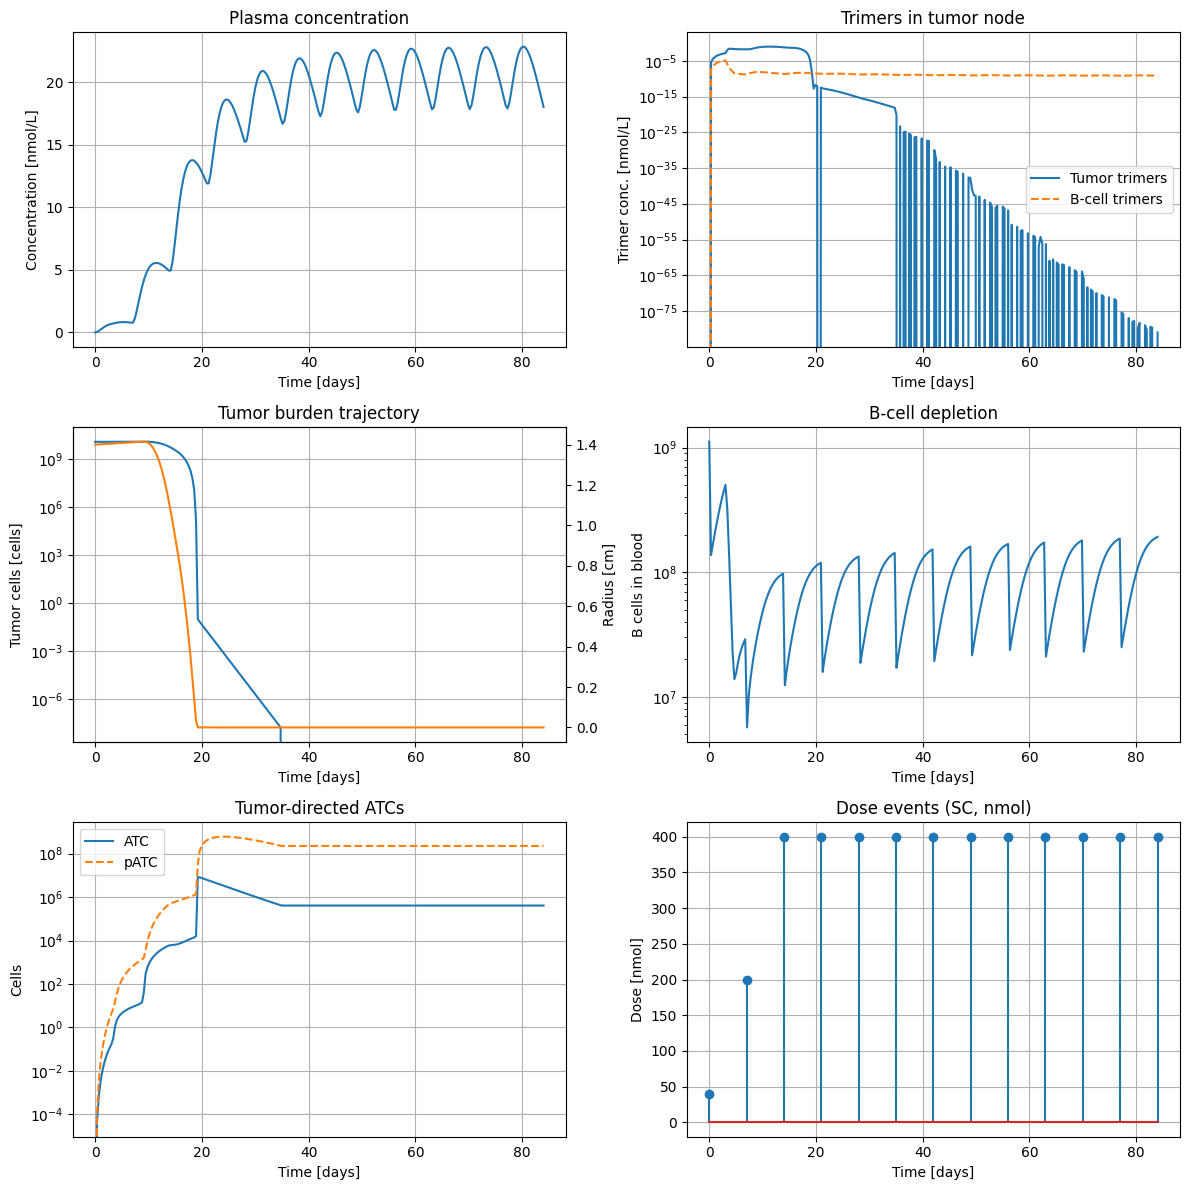

In [15]:
from src.epco_model.parameters import get_default_parameters
from src.epco_model.simulation import simulate_patient
from src.epco_model.state_vector import StateIx
from src.epco_model.dosing import clinical_phaseI_regimen_mg
from src.epco_model import plotting as epplot

params = get_default_parameters()

dosing = clinical_phaseI_regimen_mg(
    full_mg=60.0, 
    priming_fraction=0.1, # 10% priming on Day 1
    intermediate_fraction=0.5,
    t_end=84.0,
    first_dose_day=0.0,
)

t, y = simulate_patient(params, dosing, t_span=(0.0, 84.0))

# Summary stats
pk = params.pk
C_plasma = y[StateIx.DRUG_PLASMA] / pk.Vplasma
Cmax = C_plasma.max()
AUC  = np.trapezoid(C_plasma, t)

B0  = y[StateIx.B_BLOOD, 0]
B84 = np.interp(84.0, t, y[StateIx.B_BLOOD])
N0  = y[StateIx.TUMOR_CELLS_TOTAL, 0]
N84 = np.interp(84.0, t, y[StateIx.TUMOR_CELLS_TOTAL])

print(f"Cmax_plasma: {Cmax:.3f} nmol/L")
print(f"AUC_plasma (0–84d): {AUC:.3f} nmol·day/L")
print(f"B0: {B0:.3e}, B84: {B84:.3e}, fraction: {B84/B0:.3f}")
print(f"Tumor N0: {N0:.3e}, N84: {N84:.3e}, fraction: {N84/N0:.3f}")

# diagnostic plots and dose events 
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.ravel()

epplot.plot_plasma_concentration(t, y, params, ax=axes[0])
epplot.plot_node_trimers(t, y, params, ax=axes[1])
epplot.plot_tumor_trajectory(t, y, ax=axes[2])
epplot.plot_bcell_depletion(t, y, ax=axes[3])
epplot.plot_tumor_ATCs(t, y, ax=axes[4])

# 6th panel: dosing stem plot
dose_times   = [e.time for e in dosing.events]
dose_amounts = [e.amount for e in dosing.events]

axes[5].stem(dose_times, dose_amounts)
axes[5].set_title("Dose events (SC, nmol)")
axes[5].set_xlabel("Time [days]")
axes[5].set_ylabel("Dose [nmol]")
axes[5].grid(True)

plt.tight_layout()
plt.show()